# Semantic Segmentation 프로젝트
# - 인물사진 모드 만들기
## 목차
1. DeepLab Model
2. 이미지 배경 블러 처리
3. 배경 합성
4. 문제점
5. 해결방안

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 1. DeepLab Model

### - DeepLab Model 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    #__init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    #tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됨. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    #이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환.
    #모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, 
    #OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    #실제로 세그멘테이션을 하는 함수.
    def run(self, image):
        img_input = self.preprocess(image)

        #Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### - 사전에 학습된 가중치 불러오기

In [4]:
#define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


### - DeepLab에서 제공하는 PASCAL VOC 라벨 종류

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

# 2. 이미지 배경 블러 처리

In [6]:
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'
save_dir = os.getenv('HOME')+'/aiffel/human_segmentation/new_images'

#여러가지 종류의 이미지를 처리하기 위해 블러처리하는 과정을 하나의 함수로 만듦.
def bg_blur(file_name, label) :
    
    #이미지 로드
    img_path = os.path.join(img_dir, file_name)
    img_orig = cv2.imread(img_path)
    
    #모델에 이미지 넣기
    img_resized, seg_map = MODEL.run(img_orig)
    print ('original image shape:',img_orig.shape)
    print('resized image shape:', img_resized.shape)
    print('segmentation map:', seg_map.max())
    
    #배경이랑 인물 분리 후 마스크 만들고 시각화
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) #예측 중 특정 피쳐만 추출
    img_mask = seg_map * (255/seg_map.max()) #세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화.
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)     #applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #세그멘테이션 결과를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #배경 블러 처리
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #블러처리 된 이미지에서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color) #bitwise_not 함수를 이용하면 이미지가 반전됨.
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #블러처리 된 배경과 원본 이미지 합성 후 저장
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    save_path = os.path.join(save_dir, file_name)
    cv2.imwrite(save_path, img_concat)
    print(file_name + ' '+ 'was successfully saved')
    
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

### case 1 : 상반신만 있는 사진

original image shape: (509, 494, 3)
resized image shape: (513, 497, 3)
segmentation map: 16


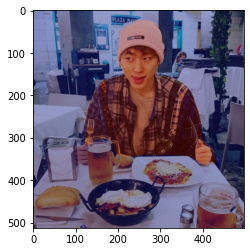

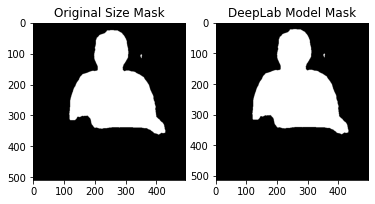

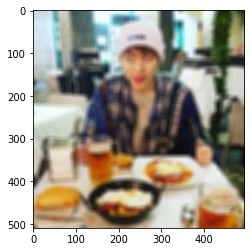

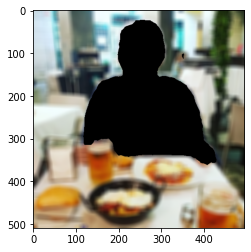

zico.jpg was successfully saved


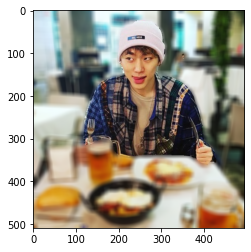

In [7]:
bg_blur('zico.jpg', 'person')

- case 1 : 상반신만 있는 사진 결과
  - 뒷 배경의 아주 작은 부분을 같이 인식을 하긴 했지만, 비교적 깔끔하게 인물만 잘 인식하여 배경 블러처리가 깔끔하게 되었다.

### case 2 : 전신 사진

original image shape: (856, 640, 3)
resized image shape: (513, 383, 3)
segmentation map: 15


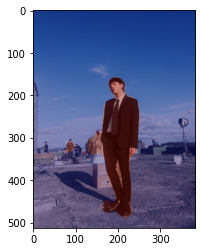

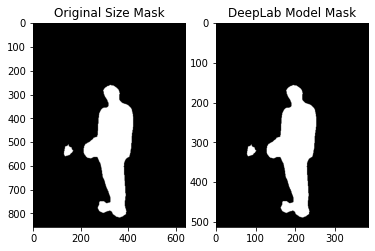

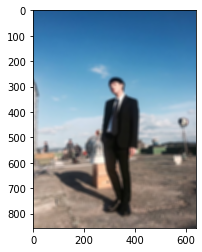

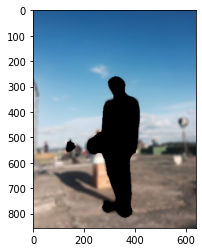

zico2.jpg was successfully saved


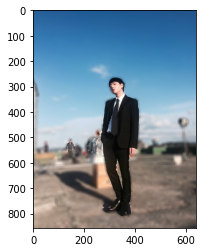

In [8]:
bg_blur('zico2.jpg', 'person')

- case 2 :전신만 있는 사진 결과
  - 전신을 전부 잘 인식하였지만 뒤에 엑스트라로 나온 사람까지 같이 인식을 함. 또, 바로 뒷 배경과 함께 '사람'으로 인식되었음.

### case 3 : 인물 그림

original image shape: (1242, 1242, 3)
resized image shape: (513, 513, 3)
segmentation map: 15


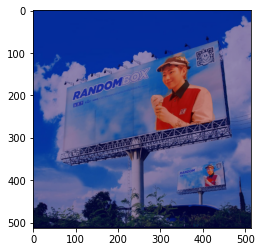

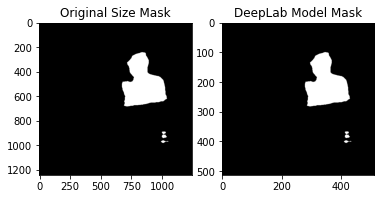

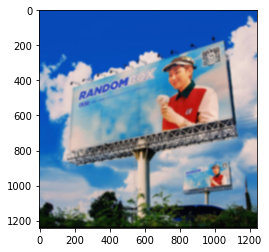

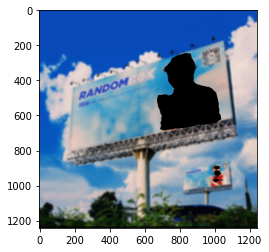

zico3.jpg was successfully saved


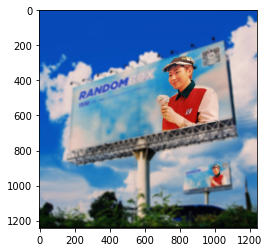

In [9]:
bg_blur('zico3.jpg', 'person')

- case 3 : 인물 그림 결과
  - 인물이 중심이 아닌 인물이 그림처럼 되어 있는 이미지도 인식이 될지 궁금했다.
  - 결과적으로 잘 인식 되었다. 심지어 뒤에 작게 있는 인물도 '사람'으로 인식이 잘 되었다.
  - 뒤에 있는 작은 인물은 앞 인물처럼 깔끔하게 인식이 되진 않았다.

### case 4 : 뒷 모습

original image shape: (1490, 1242, 3)
resized image shape: (513, 427, 3)
segmentation map: 15


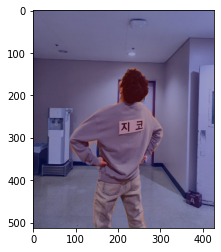

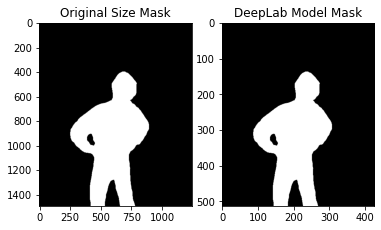

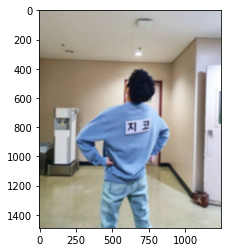

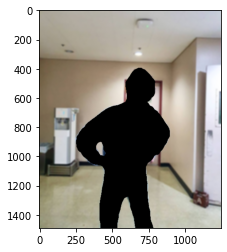

zico4.jpg was successfully saved


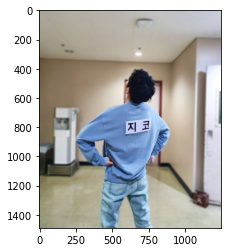

In [10]:
bg_blur('zico4.jpg', 'person')

- case 4 : 뒷모습 결과
  - 뒷모습의 인물도 잘 인식하는지 궁금했다.
  - 뒷모습도 아주 깔끔하게 인식하고 배경 블러처리도 깔끔하게 잘 되었다.

### case 5 : 거울 샷

original image shape: (1209, 889, 3)
resized image shape: (513, 377, 3)
segmentation map: 15


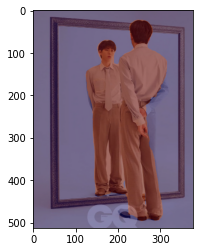

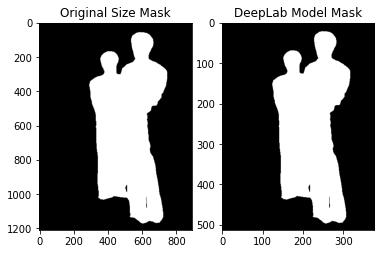

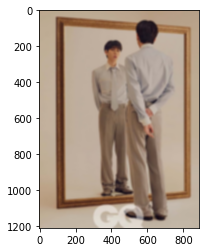

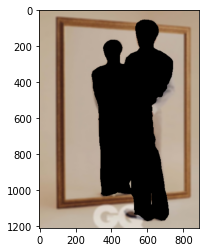

zico5.jpg was successfully saved


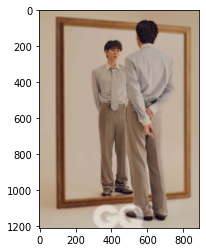

In [11]:
bg_blur('zico5.jpg', 'person')

- case 5 : 거울샷 결과
  - 거울에 비친 인물도 잘 인식할지 궁금했다.
  - 의외로 겨울에 비친 앞 모습은 잘 인식하였는데 실제 모습인 뒷 모습은 팔부분이 잘 인식이 되지 않았다.

### case 6 : 인물과 동물이 같이 있는 사진

original image shape: (738, 1242, 3)
resized image shape: (304, 513, 3)
segmentation map: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


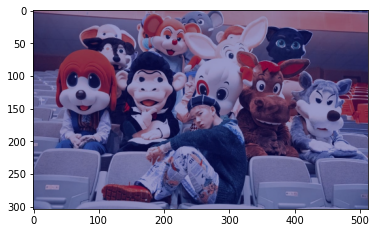

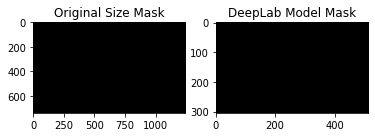

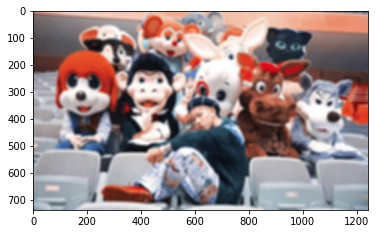

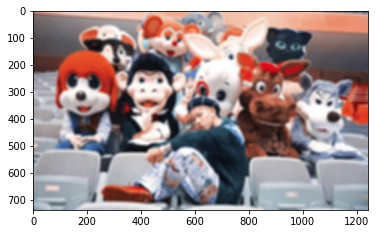

zico6.jpg was successfully saved


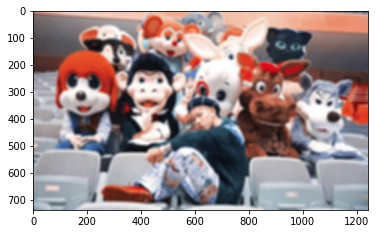

In [12]:
bg_blur('zico6.jpg', 'person')

- case 6 : 인물과 동물이 같이 있는 사진 결과
  - 인물과 동물이 같이 있는 사진에서 라벨은 'person'으로 하면 사람만 잘 인식 할 지 궁금했다.
  - 결론은 사람조차 인식을 하지 못했다. 
  - segmentation map의 max 값으로 12, 즉 'dog'가 나와서 혹시나 하고 라벨에 'dog'를 넣어봤지만 동물들도 인식을 하지 못했다.

### case 7 : 여러 명의 인물이 있는 사진

original image shape: (881, 1242, 3)
resized image shape: (363, 513, 3)
segmentation map: 15


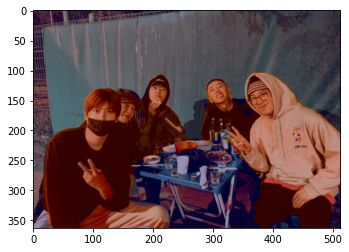

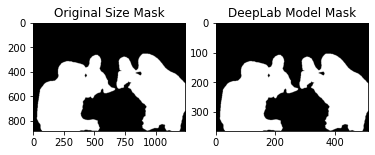

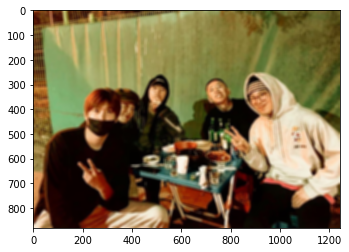

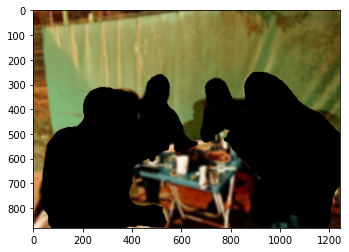

bb.jpg was successfully saved


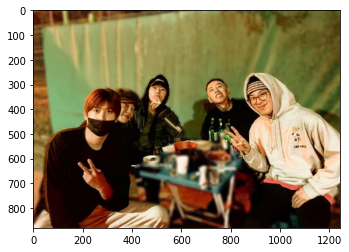

In [13]:
bg_blur('bb.jpg', 'person')

- case 7 : 여러 명의 인물이 있는 사진 결과
  - 5명의 인물 모두 잘 인식되었다. 
  - 하지만 인물 앞에 있는 약간의 사물도 함께 인식이 되었으며 가장 좌측에 있는 인물의 다리의 일부분이 인식이 되지 않았다.

### case 8 : 고양이 사진

original image shape: (3023, 3015, 3)
resized image shape: (513, 511, 3)
segmentation map: 8


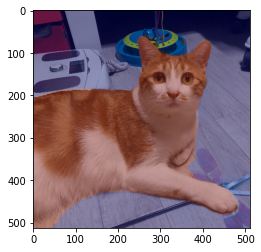

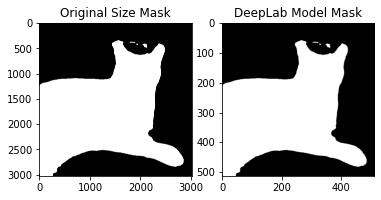

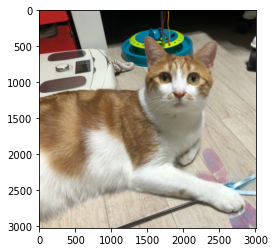

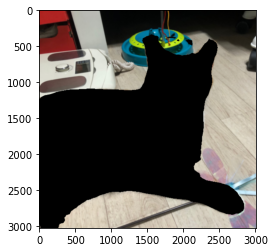

cat6.jpg was successfully saved


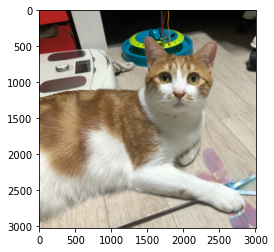

In [14]:
bg_blur('cat6.jpg', 'cat')

original image shape: (3231, 3022, 3)
resized image shape: (513, 479, 3)
segmentation map: 8


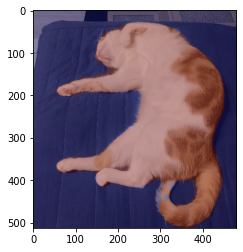

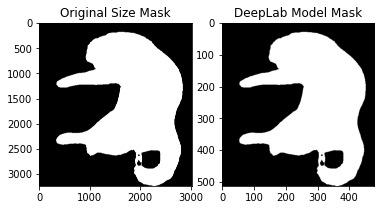

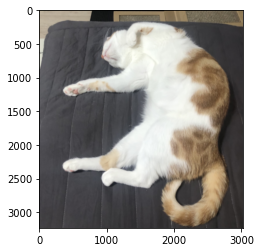

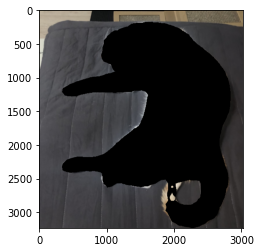

cat3.jpg was successfully saved


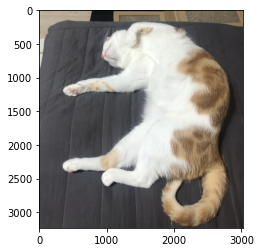

In [15]:
bg_blur('cat3.jpg', 'cat')

original image shape: (1530, 1242, 3)
resized image shape: (513, 416, 3)
segmentation map: 15


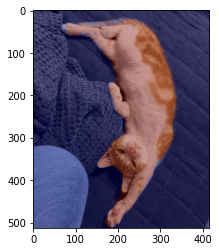

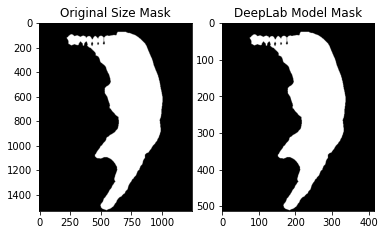

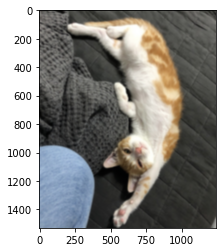

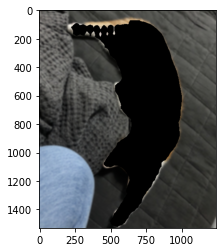

cat4.jpg was successfully saved


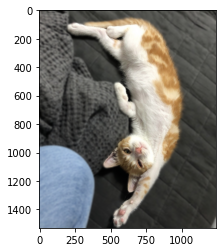

In [16]:
bg_blur('cat4.jpg', 'cat')

original image shape: (2401, 1827, 3)
resized image shape: (513, 390, 3)
segmentation map: 8


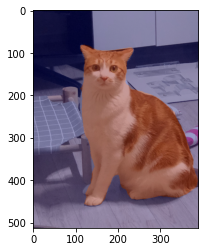

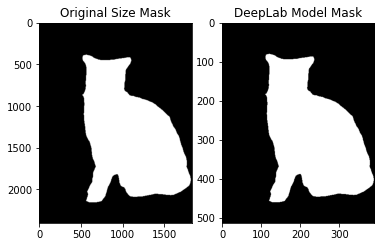

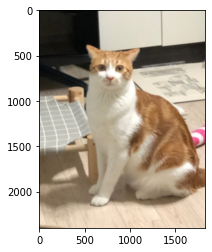

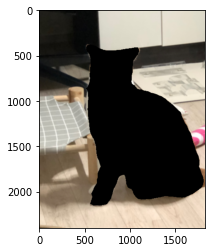

cat5.jpg was successfully saved


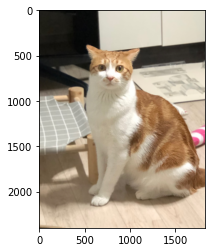

In [17]:
bg_blur('cat5.jpg', 'cat')

- case 8 : 고양이 사진 결과 (귀여운 우리집 고양이 자랑 맞습니다^^...)
  - 라벨을 'cat'으로 바꾸었더니 고양이 사진 또한 인식이 아주 잘 되었다.
  - 정석적인 고양이 얼굴, 자세가 아니라 요상한 자세의 고양이도 인식이 잘 될지 궁금해서 여러 포즈의 고양이 사진을 넣었다.
  - 아주 깔끔하게 '고양이만' 인식이 된 건 아니고 뒷 배경에 있는 사물의 일부분이 같이 인식되기도 했고, 고양이의 꼬리 부분이 완전히 인식되지 않아 듬성듬성 인식 된 결과도 있었다.

# 3. 배경 합성

In [46]:
#여러 사진에 적용하기 위해 반복되는 코드는 함수로 묶음.

def bg_chroma(file_name, label, bg_img) :
    
    #이미지 로드
    img_path = os.path.join(img_dir, file_name)
    img_orig = cv2.imread(img_path)
    
    #모델에 이미지 넣기
    img_resized, seg_map = MODEL.run(img_orig)
    print ('original image shape:',img_orig.shape)
    print('resized image shape:', img_resized.shape)
    print('segmentation map:', seg_map.max())
    
    #배경이랑 인물 분리 후 마스크 만들고 시각화
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) #예측 중 특정 피쳐만 추출
    img_mask = seg_map * (255/seg_map.max()) #세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화.
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)     #applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #세그멘테이션 결과를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #배경 이미지 로드
    bg_img_path = os.path.join(img_dir, bg_img)
    bg_orig = cv2.imread(bg_img_path)
    plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #합성 할 이미지의 원본 사이즈와 배경 이미지가 동일해야 합성할 수 있음.
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
    
    #배경 이미지와 잘라 낸 이미지 합성
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

original image shape: (3023, 3015, 3)
resized image shape: (513, 511, 3)
segmentation map: 8


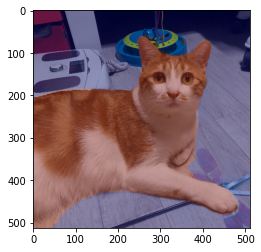

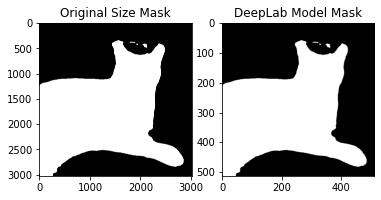

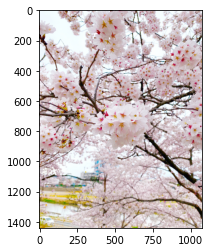

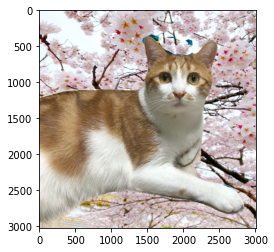

In [47]:
bg_chroma('cat6.jpg', 'cat', 'bg2.jpg')

original image shape: (1530, 1242, 3)
resized image shape: (513, 416, 3)
segmentation map: 15


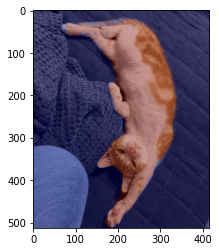

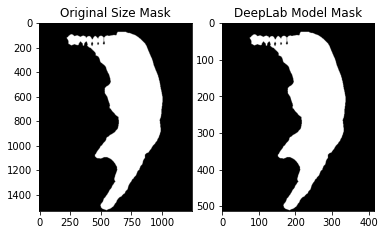

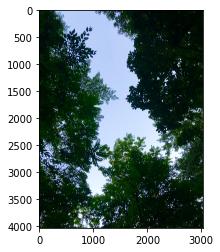

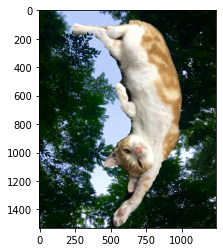

In [48]:
bg_chroma('cat4.jpg', 'cat', 'bg1.jpg')

# 4. 문제점

## - 인물 사진에 대한 문제점들
### case 1 ~ case 7
![결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex08/results/result.jpg?raw=true)
![결과2](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex08/results/result2.JPG?raw=true)

## 고양이 사진에 대한 문제점들
![결과3](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex08/results/result3.jpg?raw=true)

## - 공통적인 문제점들
1. 깔끔하지 않은 경계
  - 피사체의 영역이 배경과 맞물려서 피사체와 블러처리 된 배경과의 경계가 아주 뚜렷하게 보인다.
  - 피사체를 분리하고 블러처리 한 배경에 합성하는 과정에서 깔끔하게 피사체만 분리되지 않아서 경계선이 뚜렷하게 생기는 것이 아닐까?
2. 피사체임에도 인식을 하지 못한다.
  - 인식해야 할 피사체임에도 제대로 인식을 하지 못해 배경으로 처리되어 블러 처리가 된다.
  - 학습이 제대로 되지 않아 해당 피사체가 맞는지 아닌지 구별을 제대로 하지 못하는 것이 아닐까?

3. 피사체가 아닌데도 피사체로 인식한다.
  - 배경 영역임에도 피사체로 인식하여 블러 처리가 제대로 되지 않는다.
  - 2번과 마찬가지로 학습이 제대로 되지 않았기 때문이지 않을까 생각해보았다.

## - 인물 사진에서 나타난 문제점들
- 주가 되는 피사체 뒤 쪽에도 인물이 있을 경우 같이 인물로 인식이 되기는 하나 깔끔하게 인식이 되지 않아 배경과 같이 블러 처리가 되는 영역도 있다.   
  - 화질이 좋지 않은 사진일 수록 블러처리가 되는 영역이 넓어지는 것 같다.

# 5. 해결 방안

### - 깔끔하지 않은 경계
- 피사체와 블러처리 된 배경과의 경계가 뚜렷한 문제는 segmentation으로 인식한 피사체의 가장자리를 1차적으로 블러 처리 한 후에 블러 처리한 배경과 합성하면 자연스럽게 경계가 처리 될 것 같다.    

### - 주가 되는 피사체와 같은 종류의 뒤 쪽에 위치한 피사체의 부정확한 인식
- 주가 되는 피사체는 뒤 쪽에 위치한 피사체와 크기가 아주 큰 차이가 있기 때문에 segmenatation으로 인식한 피사제의 크기로 주가 되는 피사체로 인식할지, 인식하지 않을지 고를 수 있을 것 같다. 

### - 피사체가 아님에도 피사체로 인식하거나, 피사체임에도 배경으로 인식
- [Mask Policy 방법에 대한 링크](https://tech.socarcorp.kr/data/2020/02/13/car-damage-segmentation-model.html)를 통해 sgmentation 학습 후 이진 마스크를 출력하는 과정에 대해서 자세히 알 수 있었다.
- 학습이 완료된 Segmentation Network 내부 파라미터와의 연산을 통해 모델의 출력되는 예측값은 2차원 예측 마스크이며 이 예측 마스크는 Mask Policy에 의해 0과 1의 이진 마스크로 변환된다. 
- 0과 1 사이의 연속적인 확률값을 '속한다' 또는 '속하지 않는다'라는 이산적인 클래스 정보로 변환하는 과정을 거친다.
- 이 과정에서 사용할 수 있는 클래스 별 특성을 반영한 방법은 2가지이다.
  - Thresholding 방식으로 Binary Mask 생성.
  - CRF 방식으로 Binary Mask 생성.
- 세밀한 경계 설정이 가능한 CRF 방식과 특정 확률값에 기반하는 Thresholding 방식으로 생성된 예측 마스크에 후처리를 해 줄 수 있을 것 같다고 생각했다.
- 따라서 각 클래스마다 다른 변환 정책을 적용함으로써 각 클래스의 특성이 반영된 이진 마스크를 생성하여 경계에 대한 문제점도 해결하고 피사체를 인식하는 영역을 좀 더 디테일하게 정할 수 있지 않을까 생각했다.